# Test Task Bid Ask Spread

## Predict Bid Ask spread using only volumes on each level


In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


plt.style.use('seaborn')
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(15,9)})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18,9)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Let's investigate our data

In [3]:
test = pd.read_csv('test.csv')
test

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,VASK0_PREV,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV
0,187,341,385,375,323,134,158,213,222,180,187,341,385,375,323,134,158,212,222,180
1,37,165,144,160,146,89,101,184,162,123,38,165,144,160,146,89,101,185,162,123
2,195,192,211,178,188,18,114,162,163,167,195,192,211,178,188,18,114,162,163,167
3,5,180,143,159,194,109,127,224,133,132,5,180,143,159,194,110,127,224,133,132
4,117,156,154,169,139,48,129,148,159,177,117,156,154,169,139,48,128,148,159,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93291,73,223,216,249,192,143,208,199,240,231,75,223,216,249,192,143,208,199,240,231
93292,33,109,172,171,223,92,218,125,106,217,40,109,172,171,223,92,218,125,106,217
93293,138,140,198,146,142,39,80,124,170,183,138,140,198,146,142,39,72,124,170,183
93294,145,201,127,160,157,34,123,185,177,158,145,201,127,160,157,33,123,185,177,158


In [4]:
train = pd.read_csv('train.csv')
train

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,...,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
0,108,276,224,196,195,132,181,253,207,185,...,276,224,196,195,136,181,253,207,185,0
1,47,132,197,236,188,81,146,193,169,192,...,132,197,236,188,81,146,193,169,192,0
2,93,172,193,226,232,33,128,168,145,140,...,172,193,226,232,33,128,168,145,140,0
3,62,104,169,188,140,75,165,151,206,105,...,104,169,188,140,81,165,151,206,105,0
4,40,43,87,110,99,11,66,77,155,364,...,43,87,110,99,11,66,77,153,364,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186585,82,170,163,162,160,20,121,143,152,93,...,170,163,162,160,18,121,143,152,93,0
186586,32,176,214,299,265,261,235,232,229,238,...,176,215,299,265,261,235,232,229,238,0
186587,95,226,159,203,137,54,143,155,133,194,...,226,159,203,137,53,143,155,133,194,0
186588,140,223,297,316,561,61,211,224,254,244,...,223,297,316,561,61,211,224,254,244,0


### As we can see below our data is higly imbalanced

0    184676
1      1914
Name: Y, dtype: int64


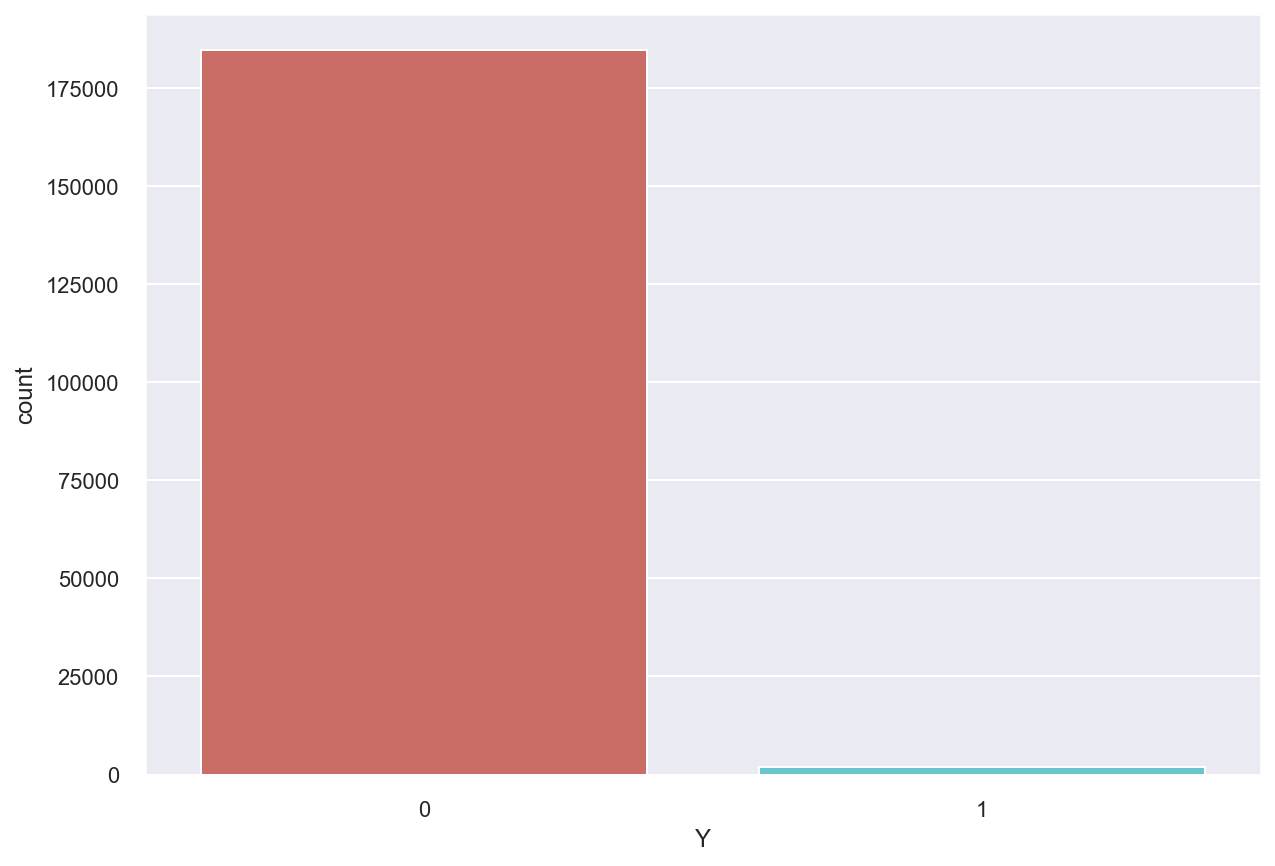

In [5]:
print(train['Y'].value_counts())
sns.set(rc={'figure.figsize':(10,7)})
sns.countplot(x='Y', data=train, palette='hls');

### I will use the following formula to identify bid ask imbalance on every price level

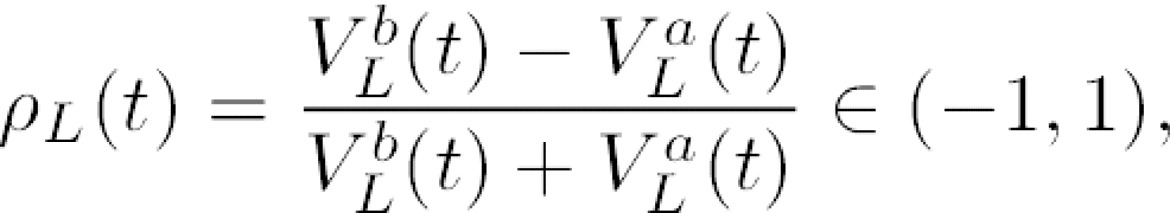

In [6]:
def calculate_imbalance(train: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate imbalance dataframe -> return pandas DataFrame with new feature
    """
    train.drop(['VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV', 'VASK3_PREV', 'VASK4_PREV',	'VBID0_PREV', 'VBID1_PREV',	'VBID2_PREV', 'VBID3_PREV',	'VBID4_PREV'], axis=1, inplace=True)
    imbalance = pd.DataFrame(columns=[f'l{i}' for i in range(5)])
    values = list(imbalance.columns)
    
    asks = train.iloc[:,0:5]
    bids = train.iloc[:,5:10]
    bids_cumsum = bids.cumsum(axis=1)
    asks_cumsum = asks.cumsum(axis=1)
    
    keys = list(bids_cumsum.columns)
    columns_dict = dict(zip(keys, values))
    
    bids_cumsum.rename(columns=columns_dict, inplace=True)
    
    keys = list(asks_cumsum.columns)
    columns_dict = dict(zip(keys, values))
    
    asks_cumsum.rename(columns=columns_dict, inplace=True)
    
    imbalance = bids_cumsum.sub(asks_cumsum) / bids_cumsum.add(asks_cumsum)
    return imbalance

In [7]:
train = pd.read_csv('train.csv')
imbalance = calculate_imbalance(train)
imbalance

,l0,l1,l2,l3,l4
0,0.100000,-0.101865,-0.035775,-0.019658,-0.020950
1,0.265625,0.118227,0.055276,-0.019151,-0.012018
2,-0.476190,-0.244131,-0.163914,-0.181347,-0.197386
3,0.094891,0.182266,0.077135,0.066071,0.028571
4,-0.568627,-0.037500,-0.049383,0.049236,0.279468
...,...,...,...,...,...
186585,-0.607843,-0.282443,-0.187411,-0.139191,-0.164297
186586,0.781570,0.409091,0.266087,0.140644,0.095828
186587,-0.275168,-0.239382,-0.153846,-0.169521,-0.094063
186588,-0.393035,-0.143307,-0.141869,-0.130939,-0.214540


### Let's look at our data

We can see that the data is imbalanced on the first level the most,

as we get up in the order book we becoming more and more balanced i.e supply equals demand

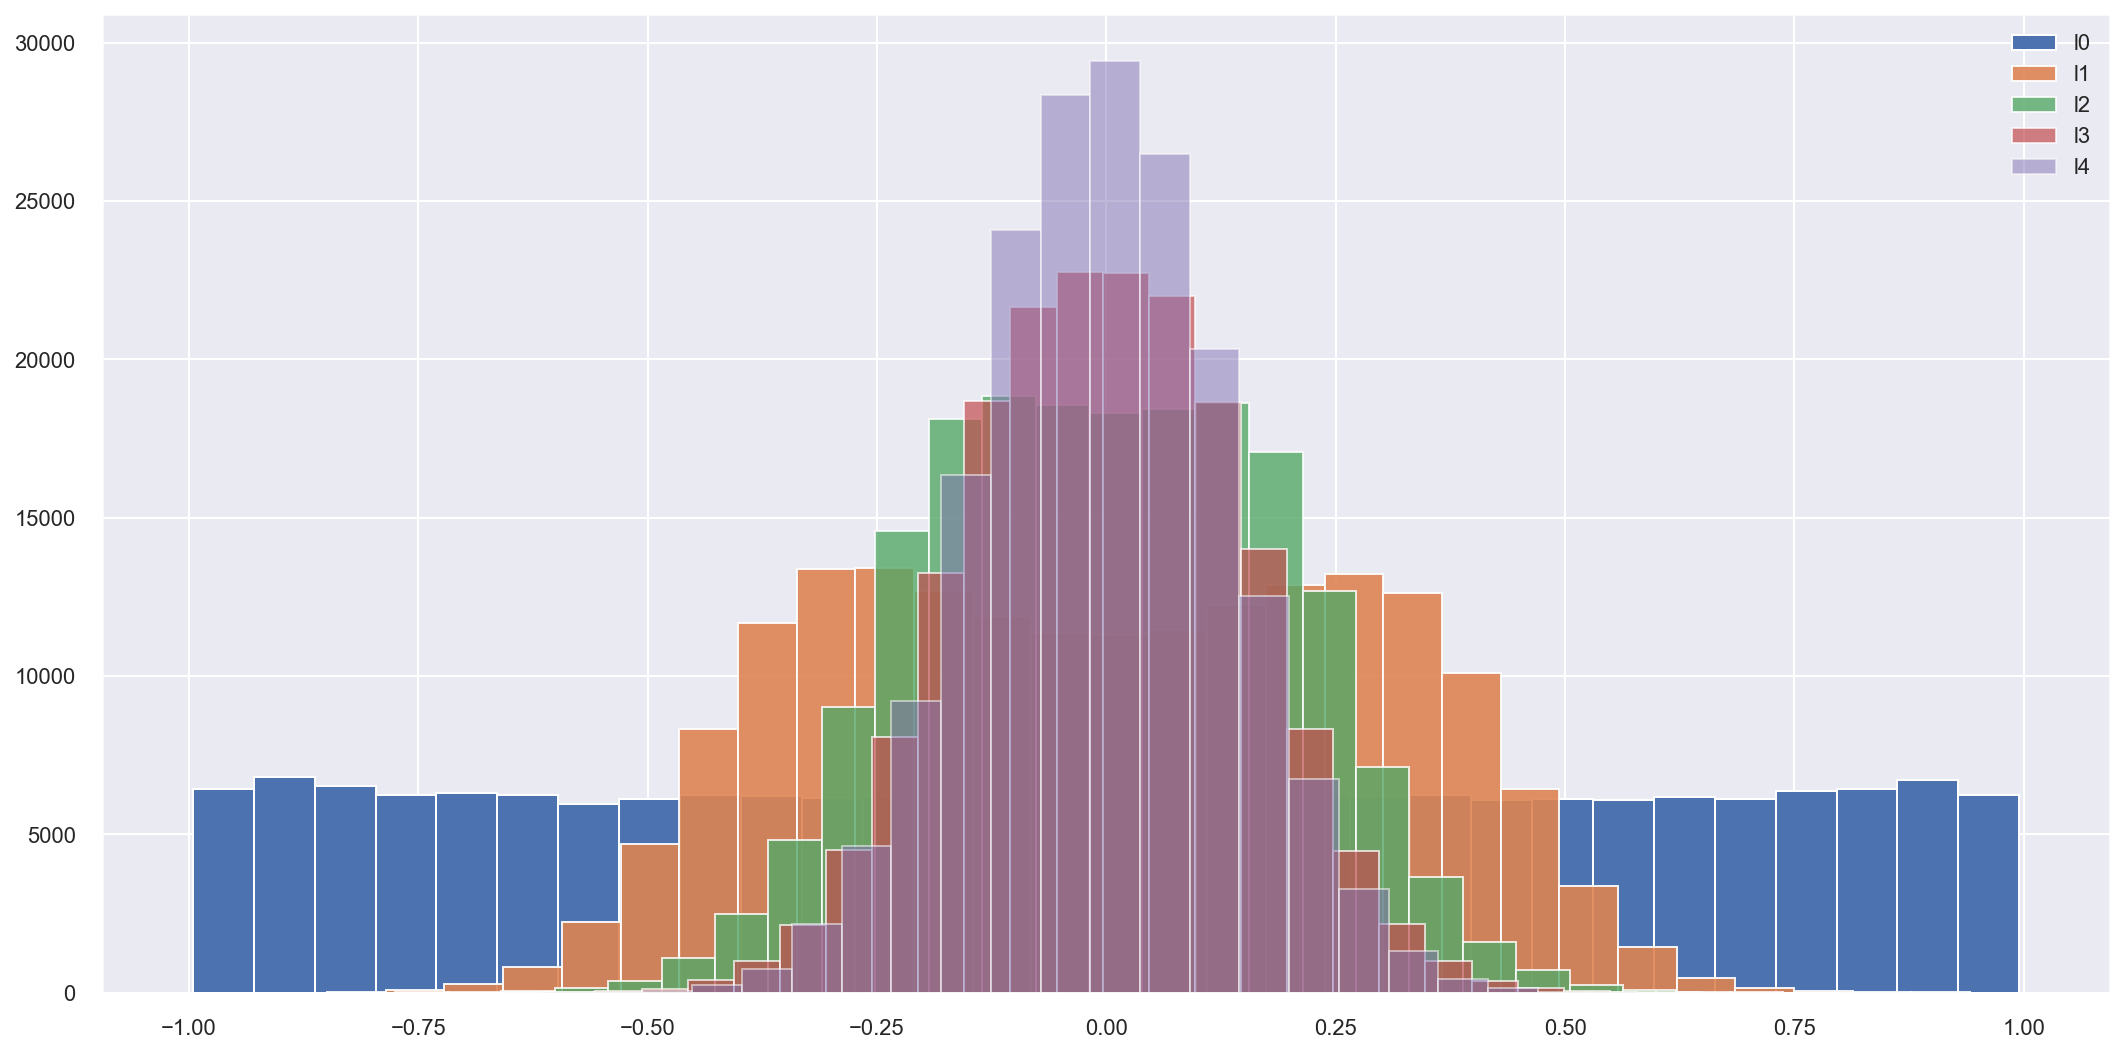

In [8]:


imbalance['l0'].hist(figsize=(18,9), bins=30, legend=True);
imbalance['l1'].hist(bins=30, alpha=0.9, legend=True);
imbalance['l2'].hist(bins=30, alpha=0.8, legend=True);
imbalance['l3'].hist(bins=30, alpha=0.7, legend=True);
imbalance['l4'].hist(bins=30, alpha=0.5, legend=True);


In [9]:
X_train, X_test, y_train, y_test = train_test_split(imbalance, train.Y, test_size=0.2)


logmodel = LogisticRegression(solver='liblinear', max_iter=100)
result = logmodel.fit(X_train, y_train)

y_pred = logmodel.predict(X_test)

print('Not 0 values 1 method', np.count_nonzero(y_pred))
print('Not 0 values 2 method', np.where(y_pred == 1)[0].size)

print('Logistic Regression Train accuracy %s' % logmodel.score(X_train, y_train)) #Train accuracy
#Logistic Regression Train accuracy 0.8333333333333334
print('Logistic Regression Test accuracy %s' % metrics.accuracy_score(y_pred, y_test)) #Test accuracy
#Logistic Regression Test accuracy 0.5

Not 0 values 1 method 0
Not 0 values 2 method 0
Logistic Regression Train accuracy 0.9897502545688408
Logistic Regression Test accuracy 0.9897100594887186


In [10]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[36934,     0],
       [  384,     0]])

Text(0.5, 447.52, 'Predicted label')

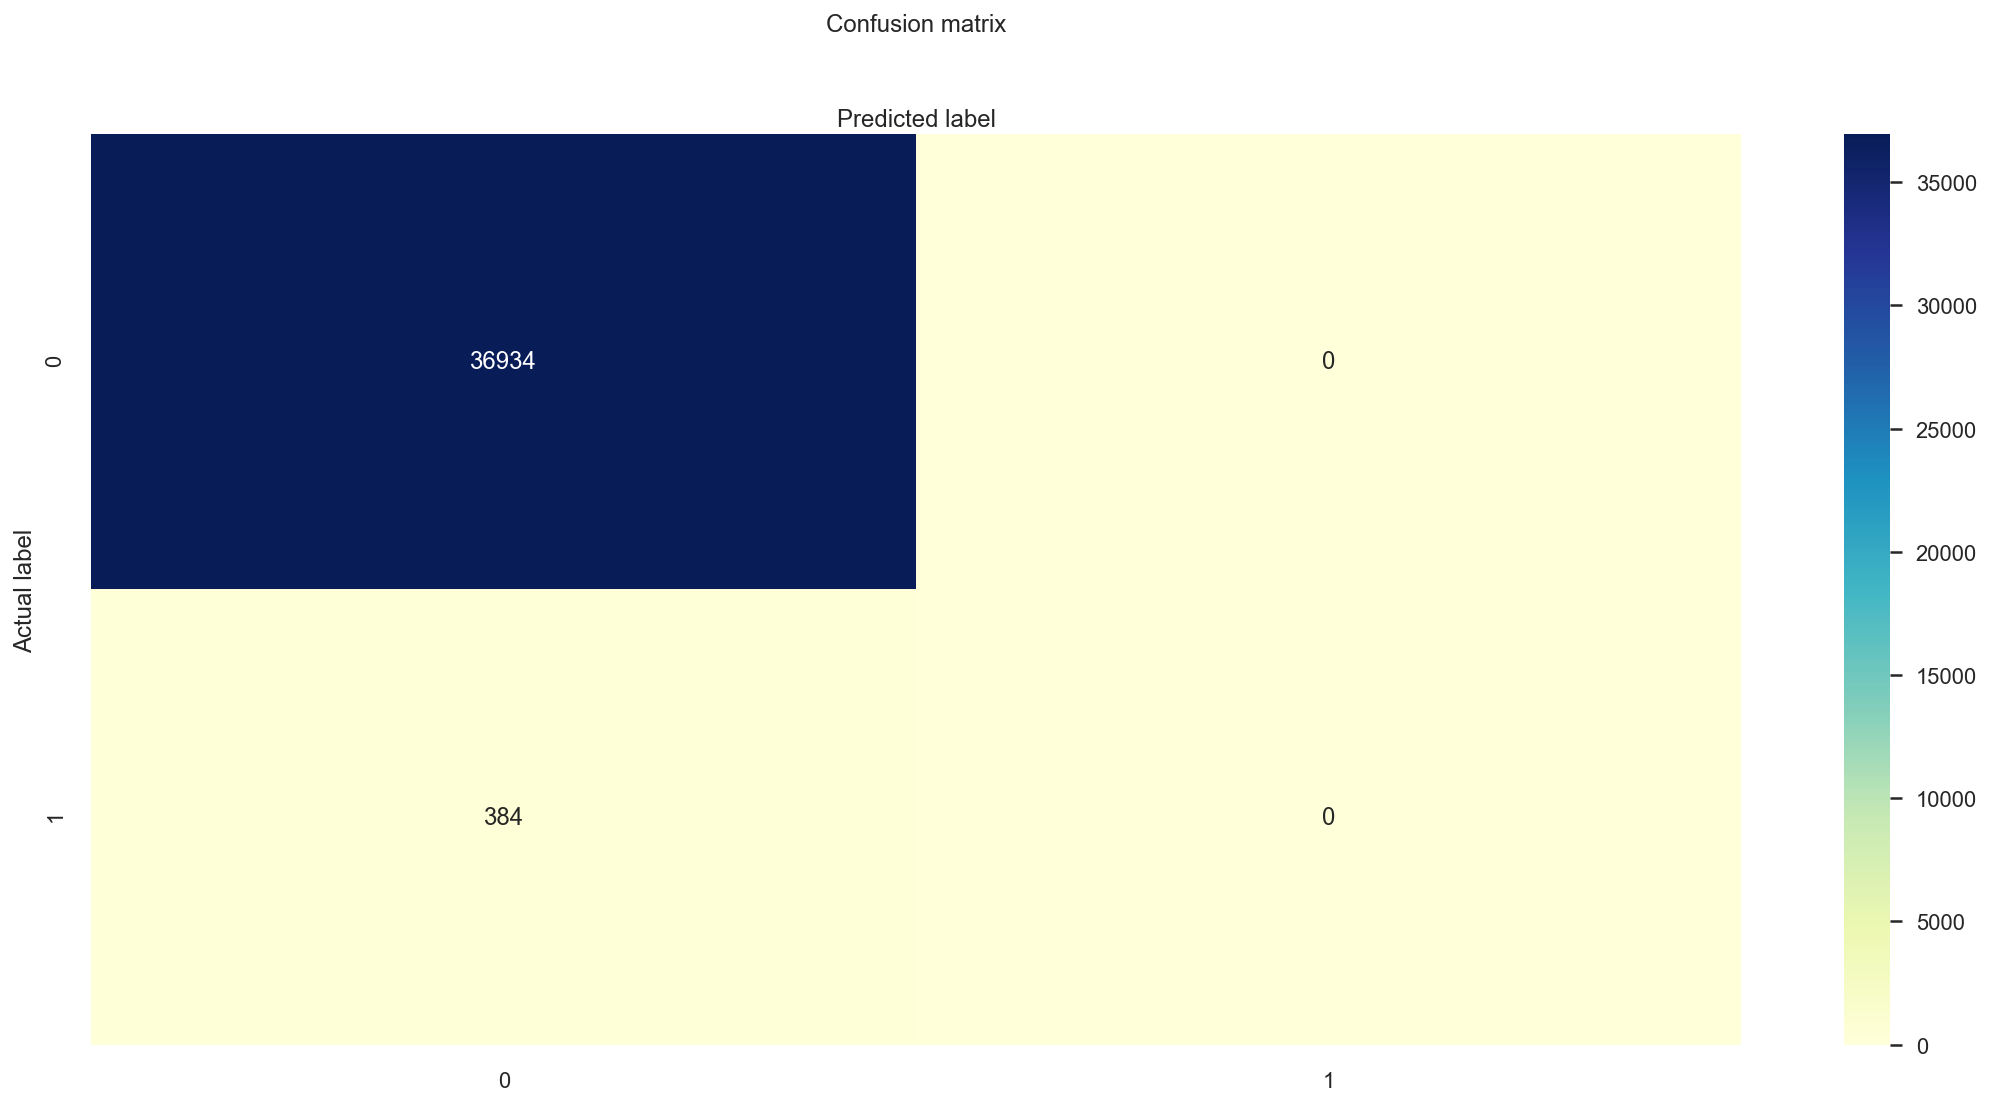

In [11]:

class_names=[0,1]
fig, ax = plt.subplots(figsize=(15,7))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


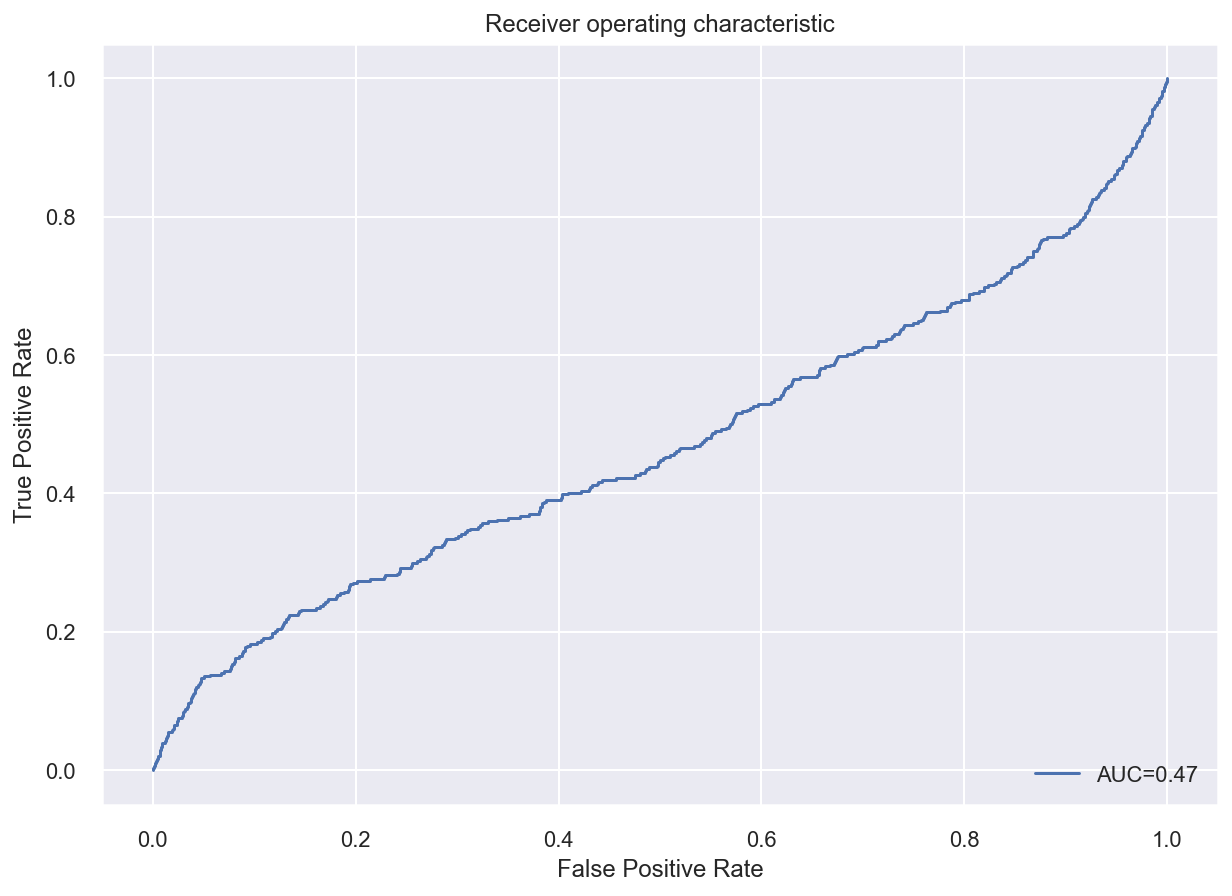

In [12]:
y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4);

### Our previous model features does not make much sense so lets try new features: difference in quantity between current and previous observations

In [13]:
def calculate_spread(train: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate imbalance dataframe -> return pandas DataFrame with new features
    """
    # train.drop(['VASK0_PREV', 'VASK1_PREV', 'VASK2_PREV', 'VASK3_PREV', 'VASK4_PREV',	'VBID0_PREV', 'VBID1_PREV',	'VBID2_PREV', 'VBID3_PREV',	'VBID4_PREV'], axis=1, inplace=True)
    spread = pd.DataFrame(columns=[f'diff{i}' for i in range(10)])
    values = list(spread.columns)
    
    curr = train.iloc[:,0:10]
    prev = train.iloc[:,10:20]
    
    keys = list(curr.columns)
    columns_dict = dict(zip(keys, values))
    
    curr.rename(columns=columns_dict, inplace=True)
    
    keys = list(prev.columns)
    columns_dict = dict(zip(keys, values))
    
    prev.rename(columns=columns_dict, inplace=True)
    
    spread = curr.sub(prev) 
    return spread

In [14]:
train = pd.read_csv('train.csv')
spread = calculate_spread(train)

spread


/Users/ivashkaleha/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,diff0,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9
0,0,0,0,0,0,-4,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,-6,0,0,0,0
4,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
186585,0,0,0,0,0,2,0,0,0,0
186586,0,0,-1,0,0,0,0,0,0,0
186587,0,0,0,0,0,1,0,0,0,0
186588,-8,0,0,0,0,0,0,0,0,0


Not 0 values 1 method 2
Not 0 values 2 method 2


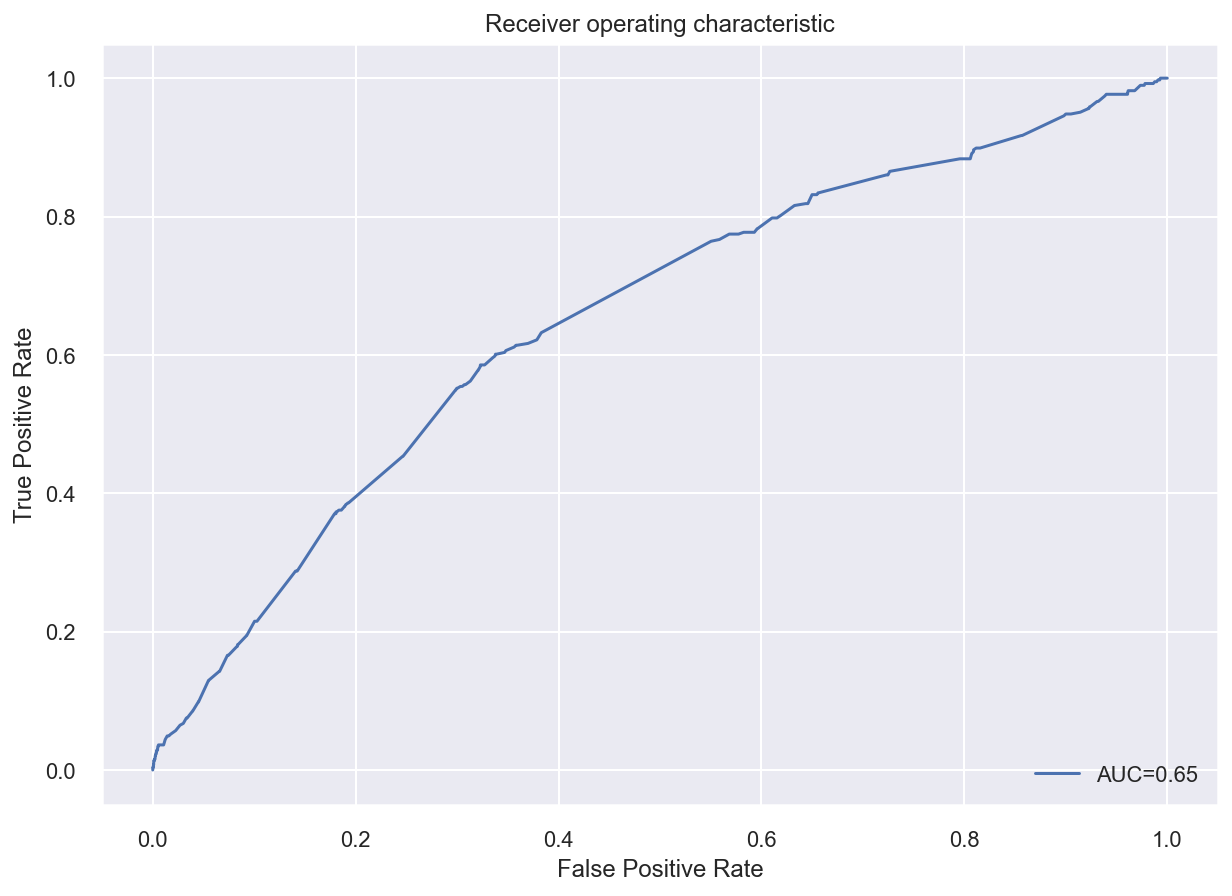

In [15]:
X_train, X_test, y_train, y_test = train_test_split(spread, train.Y, test_size=0.2)


logmodel = LogisticRegression(solver='liblinear', max_iter=100)
result = logmodel.fit(X_train, y_train)

y_pred = logmodel.predict(X_test)

print('Not 0 values 1 method', np.count_nonzero(y_pred))
print('Not 0 values 2 method', np.where(y_pred == 1)[0].size)

y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4);

### Now lets try only top bid top ask as our features

Not 0 values 1 method 0
Not 0 values 2 method 0


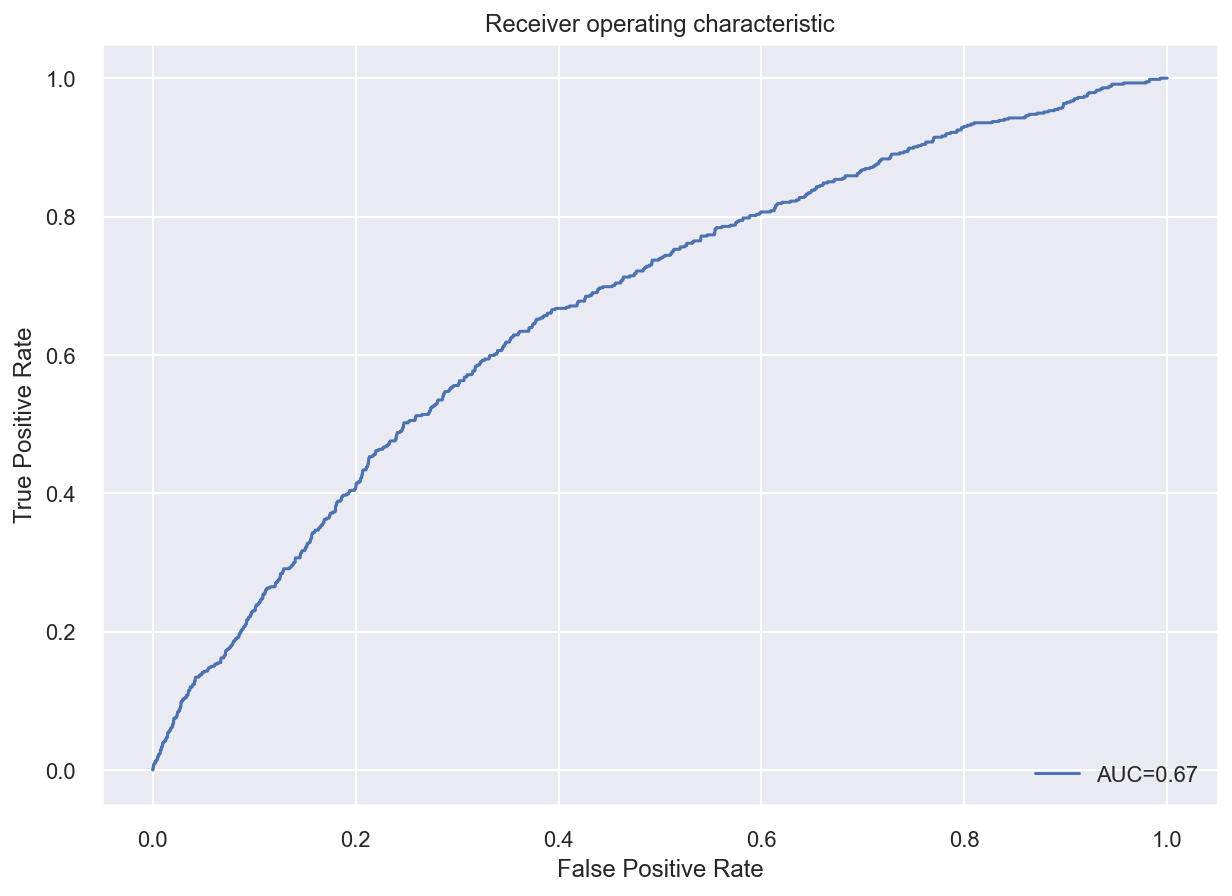

In [16]:
train = pd.read_csv('train.csv')
X_train, X_test, y_train, y_test = train_test_split(train[['VASK0', 'VBID0']], train.Y, test_size=0.3)


logmodel = LogisticRegression(solver='liblinear', max_iter=100)
result = logmodel.fit(X_train, y_train)

y_pred = logmodel.predict(X_test)


print('Not 0 values 1 method', np.count_nonzero(y_pred))
print('Not 0 values 2 method', np.where(y_pred == 1)[0].size)

y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4);

### Only current order book quantity

Not 0 values 1 method 0
Not 0 values 2 method 0


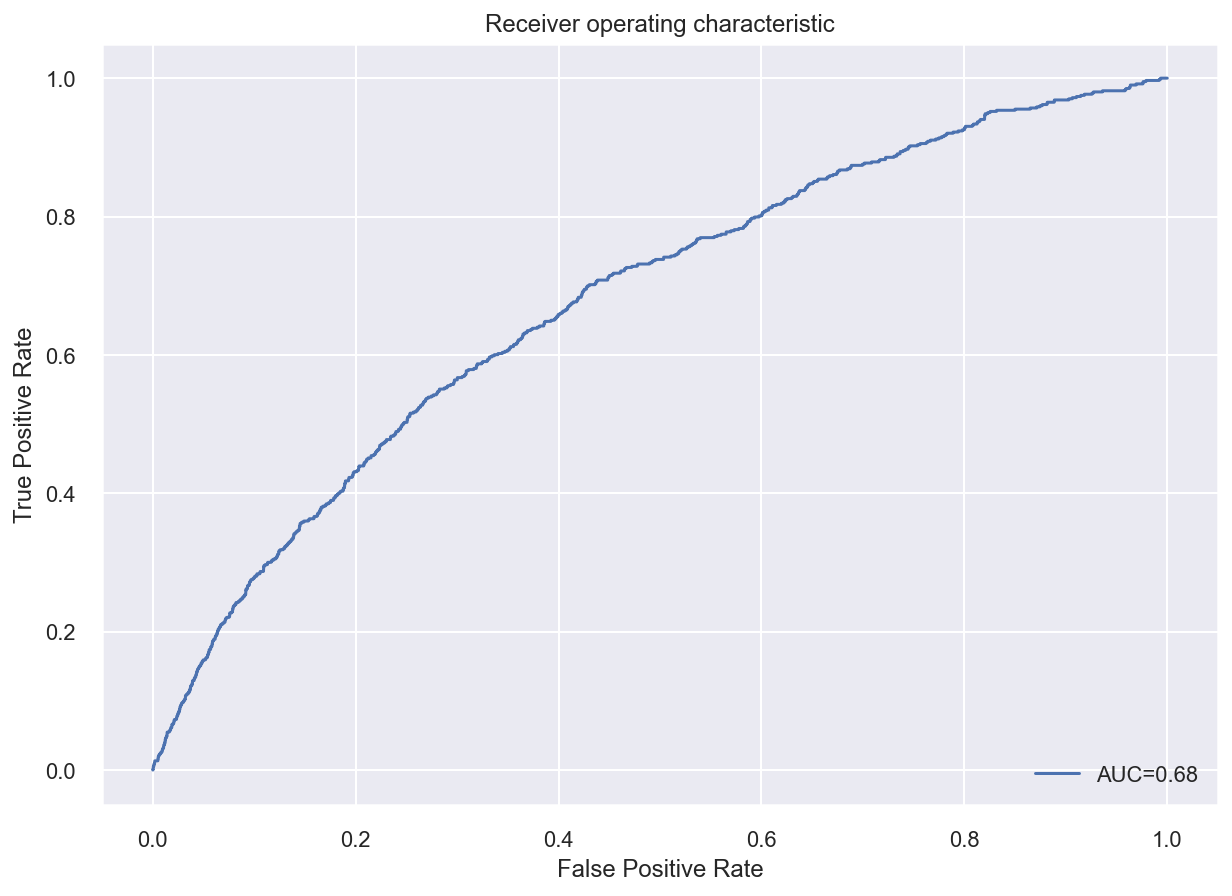

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, 0:10], train.Y, test_size=0.3)

logmodel = LogisticRegression(solver='liblinear', max_iter=100)
result = logmodel.fit(X_train, y_train)

y_pred = logmodel.predict(X_test)


print('Not 0 values 1 method', np.count_nonzero(y_pred))
print('Not 0 values 2 method', np.where(y_pred == 1)[0].size)


y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4);

### Previous step order book levels

Not 0 values 1 method 0
Not 0 values 2 method 0


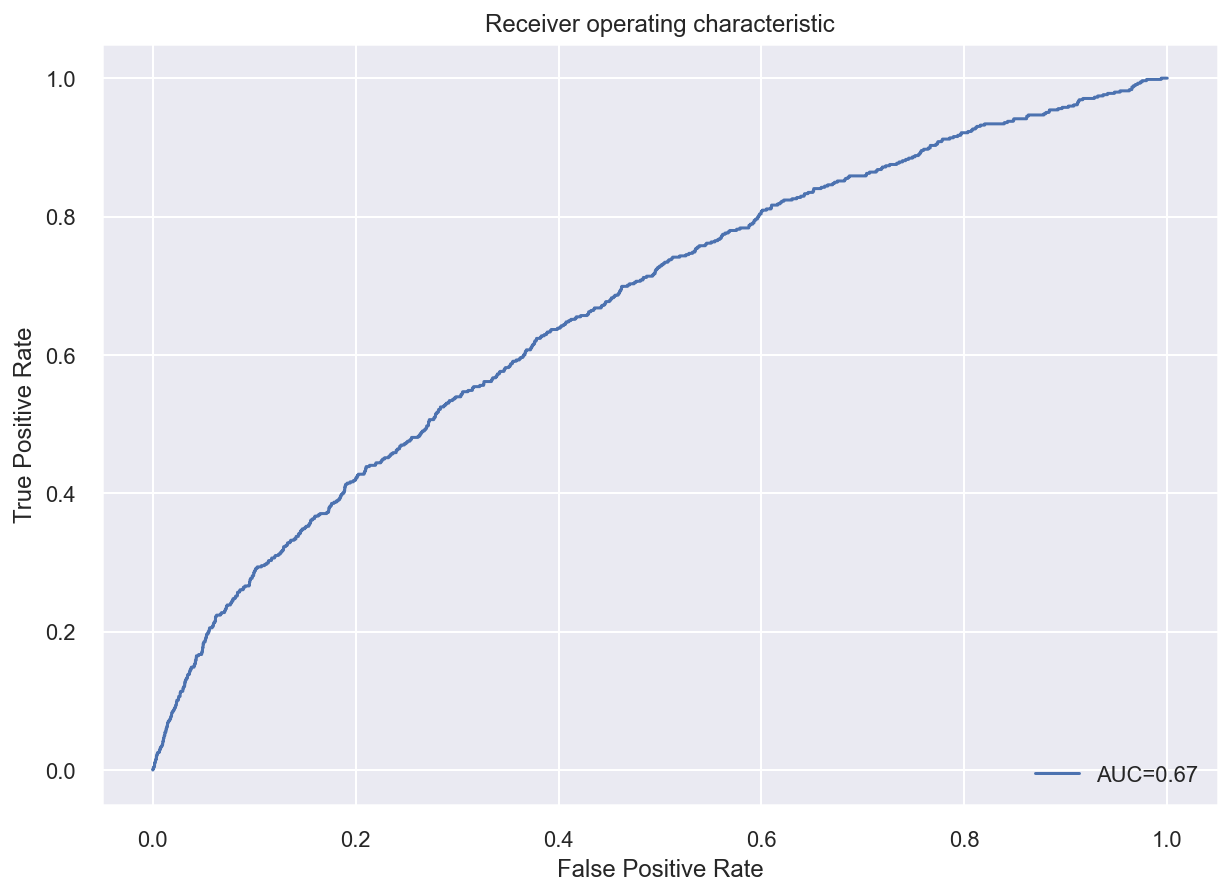

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, 10:20], train.Y, test_size=0.3)

logmodel = LogisticRegression(solver='liblinear', max_iter=100)
result = logmodel.fit(X_train, y_train)

y_pred = logmodel.predict(X_test)


print('Not 0 values 1 method', np.count_nonzero(y_pred))
print('Not 0 values 2 method', np.where(y_pred == 1)[0].size)


y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4);

### Now we will try to use SMOTE (Synthetic Minority Oversampling Technique) to make our data more balanced and reliable

Not 0 values 1 method 184676
Not 0 values 2 method 184676
Not 0 values 1 method 64277
Not 0 values 2 method 64277


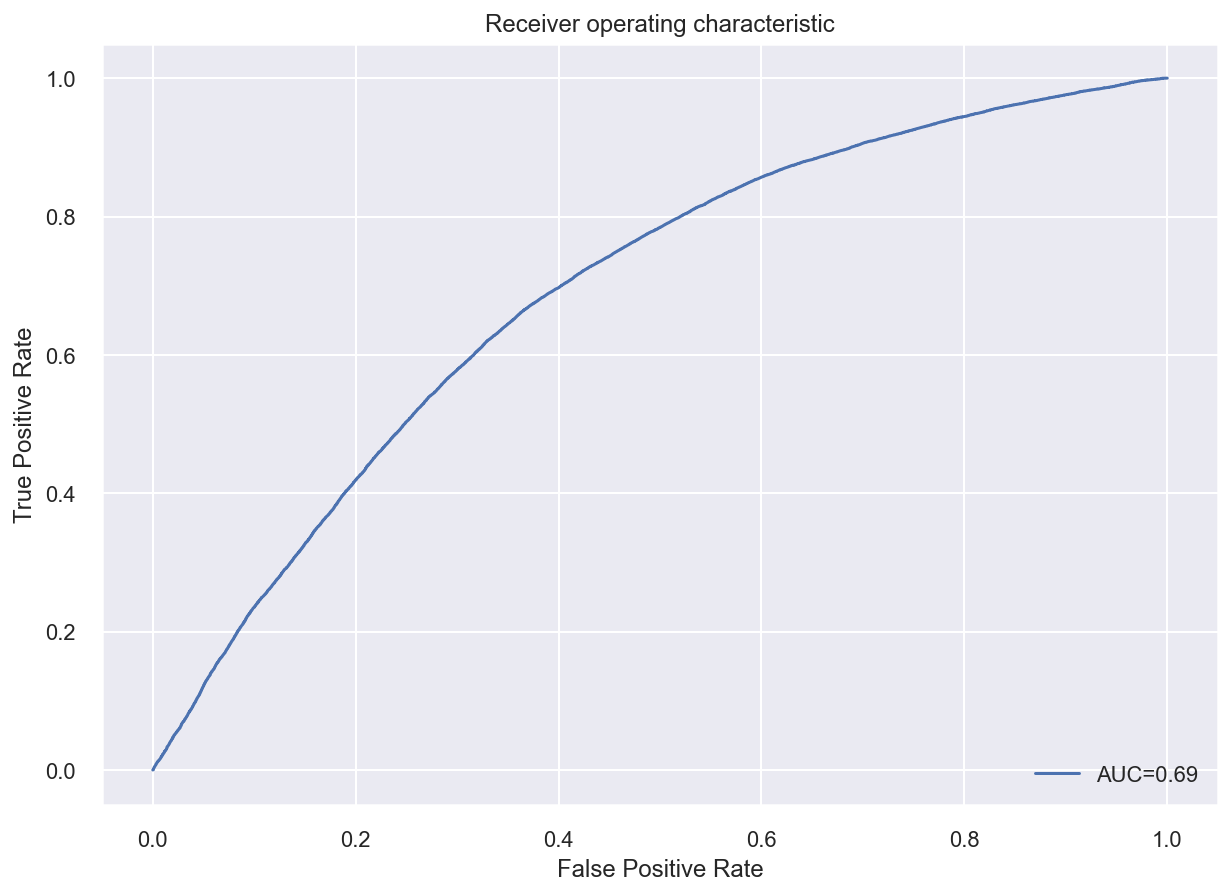

In [32]:
from imblearn.over_sampling import SMOTE



train = pd.read_csv('train.csv')

y = train.Y
X = train.iloc[:,0:10]


oversample = SMOTE()
X, y = oversample.fit_resample(X, y)


print('Not 0 values 1 method', np.count_nonzero(y))
print('Not 0 values 2 method', np.where(y == 1)[0].size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

logmodel = LogisticRegression(solver='liblinear', max_iter=100)
result = logmodel.fit(X_train, y_train)

y_pred = logmodel.predict(X_test)


print('Not 0 values 1 method', np.count_nonzero(y_pred))
print('Not 0 values 2 method', np.where(y_pred == 1)[0].size)


y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4);

### Indeed, our results became a little bit better but this model cannot be counted as reliable